# 1. Load and convert labeled data into sequential datasets

path/to/labeled_data/ 

    ├── class_0/
    │   ├── sample1.pkl
    │   ├── sample2.csv
    │   └── ...
    ├── class_1/
    │   ├── sample1.csv
    │   ├── sample2.pkl
    │   └── ...
    └── ...

dict_label={'class_0':0, 'class_1':1, ... }

In [107]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torch
from torchinfo import summary 

class LoadSeqDataset(Dataset):
    def __init__(self, file_path: str, label: int, selected_features:list, seq_num=28, gap=5, desire_class = None):
        """
        Initialize the dataset from a labeled data file by converting it to sequential format.
        
        Args:
            file_path (str): Path to the labeled data file.
            label (int): Label associated with the sequences from this file.
            seq_num (int): Length of each sequence.
            gap (int): Step size between sequences.
        """
        self.seq_num = seq_num
        self.gap = gap
        
        # Load data and process into sequences
        self.data = pd.read_csv(file_path)
        self.data.drop(columns='index', inplace=True, errors='ignore')
        self.data.label = self.data.label * label.item()
        self.df = self.data
        #self.sequences = self._make_sequences_contact_only()
        self.sequences = self._make_sequences()
        if desire_class is not None:
            self.sequences = self._get_specific_class(desire_class)

    def _make_sequences_contact_only(self):
        """Generate sequences based on the contact points detected in the data."""
        start_contact_indexs = self.df.loc[self.df.label.diff() > 0.1, :].index
        end_contact_indexs = self.df.loc[self.df.label.diff() < -0.1, :].index - 1
        contact_indexs = [idx for idx, idx2 in zip(start_contact_indexs, end_contact_indexs) if idx2 - idx >= self.seq_num]

        sequences = []
        for contact_index in contact_indexs:
            end_point = contact_index + self.seq_num
            for step in range(contact_index, end_point, self.gap):
                window = self.df[selected_features][step - self.seq_num + 1:step + 1]
                sequences.append((window.values, self.df.label[step]))
        return sequences
    
    def _make_sequences(self):
        """Generate sequences over time"""
        sequences = []
        for step in range(self.seq_num,self.data.shape[0], self.gap):
            window = self.df[selected_features][step - self.seq_num:step]
            sequences.append((window.values, self.df.label[step-1]))
        
        return sequences

    def _get_specific_class(self, desired_label):
        filtered_data = [(seq, label) for seq, label in self.sequences if label == desired_label]
        return filtered_data


    def __len__(self):
        """Return the total number of sequences in the dataset."""
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Retrieve a single sequence and label.
        
        Args:
            idx (int): Index of the sequence to retrieve.
            
        Returns:
            (tuple): (features, target) where target is the label for classification.
        """
        #TODO: multiple features should be reshaped.
        features, target = self.sequences[idx]
        features = features.T if isinstance(features, torch.Tensor) else torch.tensor(features, dtype=torch.float32).T.clone().detach()
        target = target if isinstance(target, torch.Tensor) else torch.tensor(target, dtype=torch.long).clone().detach()
        return features, target


class LoadDatasets(Dataset):
    def __init__(self, data_path:str, dict_label = None):
        """
        Load sequential dataset from a directory structure with labeled subdirectories.

            Expected directory structure:
            
            path/to/data/
                ├── class_0/
                │   ├── sample1.pkl 
                │   ├── sample2.csv
                │   └── ...
                ├── class_1/
                │   ├── sample1.csv
                │   ├── sample2.pkl
                │   └── ...
                └── ...

            Label mapping example:
            
            dict_label = {'class_0': 0, 'class_1': 1, ... }
        
        Args:
            data_path (str): Path to the data directory.
            dict_label (dict, optional): Dictionary mapping class folder names to labels.
        """
        if dict_label is None:
            dict_label = {'a': 7, 'b': 6, 'c': 5, 'd': 4, 'e': 3, 'f': 2, 'g': 1}
            #dict_label = {'link7': 7, 'link6':6, 'link5':5, 'link4':4, 'link3':3, 'link2':2, 'link1':1}

        
        self.samples = []
        self.class_to_idx = {}

        # Scan data_path for subdirectories        
        for class_name in sorted(os.listdir(data_path)):
            class_dir = os.path.join(data_path, class_name)
            if os.path.isdir(class_dir) and class_name in dict_label:
                label = dict_label[class_name]  # Look up label
                self.class_to_idx[class_name] = label
                for file_name in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, file_name)
                    if os.path.isfile(file_path):
                        self.samples.append((file_path, label))
                        
    def __len__(self):
        """Return the total number of samples."""
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Retrieve a single sample at the specified index.
        
        Args:
            idx (int): Index of the sample to retrieve.
            
        Returns:
            tuple: (file_path, label)
        """
        seq_path, label = self.samples[idx]
        return seq_path, label

# 2. load AI models

In [98]:
import argparse
import os
import time
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torchmetrics import ConfusionMatrix, Accuracy
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

def get_output(data_loader, model, device):
    model.eval()
    labels_pred = []
    labels_true = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
            output = model(X_batch) # Return the prediction for each joint step (batch_size, joint_seq)
            
            probabilities = F.softmax(output, dim=1)

            preds = probabilities.argmax(axis=1)  # shape: [batch_size]

            labels_pred.append(preds.cpu().numpy())
            labels_true.append(y_batch.cpu().numpy())

    # Convert lists to arrays
    labels_pred = np.concatenate(labels_pred, axis=0)
    labels_true = np.concatenate(labels_true, axis=0)

    # Convert numpy arrays back to tensors
    labels_pred = torch.tensor(labels_pred, dtype=torch.int64)  # Ensure long tensor for labels
    labels_true = torch.tensor(labels_true, dtype=torch.int64)  # Ensure long tensor for labels

    return labels_pred, labels_true
    
class ZScoreNormalization(nn.Module):
    def __init__(self):
        super(ZScoreNormalization, self).__init__()

    def forward(self, x):
        # Assuming input x has shape (batch_size, DOF,joint_seq)
        batch_size, DOF,joint_seq  = x.shape

        # Create a placeholder for the normalized output
        normalized_x = torch.zeros_like(x)
        
        # Apply normalization for each DOF independently
        for dof in range(DOF):
            # Normalize along the joint_seq dimension for each DOF
            mean = torch.mean(x[:, dof, :], dim=1, keepdim=True)
            std = torch.std(x[:, dof,:], dim=1, keepdim=True)
            normalized_x[:, dof, :] = (x[:, dof, :] - mean) / (std + 1e-6)  # Add epsilon to avoid division by zero
        
        return normalized_x

class lstmBlock(nn.Module):
    def __init__(self, num_features_joints=28, hidden_size=32, num_layers=3, dropout=0.5, bidirectional=False):
        super(lstmBlock, self).__init__()
        self.normalization = ZScoreNormalization()
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=num_features_joints,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0  # Apply dropout only if more than one layer
        )
        # Fully connected layer (to predict contact for each joint step)
        if bidirectional:
            self.fc = nn.Linear(hidden_size*2, 1)  
        else:
            self.fc = nn.Linear(hidden_size, 1) 
        
    def forward(self, input,lengths=None, freeze_last_layer=False):
        # Pass the input through the LSTM layer
        self.lstm.flatten_parameters()
        
        normalized_input = self.normalization(input)
        
        if lengths:
            # Pack padded sequence
            packed_input = pack_padded_sequence(normalized_input, lengths, batch_first=True, enforce_sorted=False)
            packed_lstm_out, _ = self.lstm(packed_input)

            # Unpack sequence
            lstm_out, _ = pad_packed_sequence(packed_lstm_out, batch_first=True)
        else: 
            lstm_out, (h_n, c_n) = self.lstm(normalized_input)

        # lstm_out shape: (batch_size, joint_seq, hidden_size)

        # Freeze the last layer if required
        if freeze_last_layer:
            for param in self.fc.parameters():
                param.requires_grad = False
        else:
            for param in self.fc.parameters():
                param.requires_grad = True


        joint_step_outputs = self.fc(lstm_out)  # Shape: (batch_size, joint_seq, 1)
        #return joint_step_outputs.squeeze()  # Return the prediction for each joint step (batch_size, joint_seq)

        # Squeeze to remove the last dimension
        joint_step_outputs = joint_step_outputs.squeeze(-1)  # Shape: (batch_size, joint_seq)

        # Apply sigmoid to get probabilities (contact detection)
        contact_detection = torch.sigmoid(joint_step_outputs)  # Shape: (batch_size, joint_seq)

        
        contact_detection = 1 - contact_detection.max(dim=1, keepdim=True).values   # Shape: (batch_size, 1)

        # Concatenate the contact detection with the joint step outputs
        combined_output = torch.cat((contact_detection, joint_step_outputs), dim=1)  # Shape: (batch_size, joint_seq + 1)
        
        return combined_output.squeeze()

class cnnLSTM(nn.Module):
    def __init__(self, num_features_joints=28, hidden_size=32, num_layers=3, dropout=0.5, bidirectional=False):
        super(cnnLSTM, self).__init__()
        self.normalization = ZScoreNormalization()
        
         # Define the 1D CNN layers
        self.cnn1 = nn.Conv1d(in_channels=num_features_joints, out_channels=64, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.cnn3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0  # Dropout only if num_layers > 1
        )

        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        
        # Fully connected layer
        self.fc = nn.Linear(lstm_output_size, 1)

        # Additional layer for contact detection
        self.contact_detector = nn.Linear(hidden_size * (2 if bidirectional else 1), 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        # Attention layer
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        

    def forward(self, input,lengths=None, freeze_last_layer=False):
        # Normalize input (batch_size, sequence_length, input_size)
        self.lstm.flatten_parameters()

        normalized_input = self.normalization(input)

        # Reshape for CNN: (batch_size, in_channels, sequence_length)
        cnn_input = normalized_input.permute(0, 2, 1)
        
        # Apply CNN layers
        cnn_out = self.relu(self.bn1(self.cnn1(cnn_input)))
        cnn_out = self.relu(self.bn2(self.cnn2(cnn_out)))
        cnn_out = self.relu(self.bn3(self.cnn3(cnn_out)))
        
        # Reshape for LSTM: (batch_size, sequence_length, input_size)
        cnn_out = cnn_out.permute(0, 2, 1)
        
        # LSTM layer
        if lengths:
            # Pack padded sequence
            packed_input = pack_padded_sequence(cnn_out, lengths, batch_first=True, enforce_sorted=False)
            packed_lstm_out, _ = self.lstm(packed_input)

            # Unpack sequence
            lstm_out, _ = pad_packed_sequence(packed_lstm_out, batch_first=True)
        else:
            lstm_out, _ = self.lstm(cnn_out)
        
        lstm_out = self.dropout(lstm_out)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Fully connected layer

        # Freeze the last layer if required
        if freeze_last_layer:
            for param in self.fc.parameters():
                param.requires_grad = False
        else:
            for param in self.fc.parameters():
                param.requires_grad = True

        joint_step_outputs = self.fc(lstm_out)  # (batch_size, joint_dof, 1)
        
        #return joint_step_outputs.squeeze()  # Return the prediction for each joint step (batch_size, joint_seq)

        # Squeeze to remove the last dimension
        joint_step_outputs = joint_step_outputs.squeeze(-1)  # Shape: (batch_size, joint_seq)

        # Apply sigmoid to get probabilities (contact detection)
        contact_detection = torch.sigmoid(joint_step_outputs)  # Shape: (batch_size, joint_seq)

        
        contact_detection = 1 - contact_detection.max(dim=1, keepdim=True).values   # Shape: (batch_size, 1)

        # Concatenate the contact detection with the joint step outputs
        combined_output = torch.cat((contact_detection, joint_step_outputs), dim=1)  # Shape: (batch_size, joint_seq + 1)
        
        return combined_output.squeeze()

# 3. Training

In [3]:
from torch.utils.data import random_split, DataLoader
def train_loop(model, dataset_loader,selected_features, lr, n_epochs, freeze_last_layer=False): #--> 
    model.train()
    # Use Adam optimizer and CrossEntropyLoss as the loss function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
    loss_seq = []
    lr_seq = []
    # Training loop
    for epoch in range(n_epochs):
        running_loss = []
        for trial_dataset_path, label in dataset_loader:
            
            data = LoadSeqDataset(file_path = trial_dataset_path[0], label= label[0],  selected_features= selected_features, seq_num=seq_num, gap=gap)
            
            dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
        
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device) # Move data to device
                optimizer.zero_grad()
                # Generate noise and shift as PyTorch tensors
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                
                loss.backward()
                optimizer.step()
                running_loss.append(loss.cpu().detach().numpy())

        avg_loss = np.mean(running_loss)
        print(f"Epoch: {epoch + 1}/{n_epochs} - learning rate: {optimizer.param_groups[0]['lr']:.5f}, classification loss: {avg_loss:.4f}")
        # Update the scheduler with the average loss
        scheduler.step(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < lr_threshold:
            print(f"Learning rate has dropped below the threshold of {lr_threshold}. Stopping training.")
            break
        loss_seq.append(avg_loss)
        lr_seq.append(current_lr)

    return model, loss_seq, lr_seq

def plot_loss(loss_seq, lr_seq):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot loss on the primary y-axis
    ax1.plot(loss_seq, label='Loss', color='blue', marker='o')
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Set y-axis limits for loss to include 0
    ax1.set_ylim(bottom=0, top=max(loss_seq) * 1.05)  # Adjust top limit as needed

    ax1.grid(True)

    # Create a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(lr_seq, label='Learning Rate', color='red', marker='o')
    ax2.set_ylabel('Learning Rate', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='red')

    # Set y-axis limits for learning rate to include 0
    ax2.set_ylim(bottom=0, top=max(lr_seq) * 1.05)  # Adjust top limit as needed

    # Add legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='best')

    # Improve layout
    plt.tight_layout()

    # Show the plot
    plt.show()


def validation(dataloaders, names, model,print_data = False):
    model.eval()
    accuracies = []
    with torch.no_grad():
        confusionMatrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
        accuracy_metric = Accuracy()
        for i in range(len(dataloaders)):
            y_pred, y_test = get_output(dataloaders[i], model, device)
            accuracy_metric.update(y_pred, y_test)
            accuracy = accuracy_metric.compute()
            if print_data: 
                print("Accuracy on ", names[i], ': ', accuracy)
            accuracies.append(accuracy.item()*100)  # Collect accuracy for plotting
            accuracy_metric.reset()
    return accuracies

# Bar chart plotting function
def plot_accuracies(pre_accuracies, post_accuracies, dataloader_names, model_name):
    labels = dataloader_names
    bar_width = 0.35
    index = range(len(labels))

    # Plotting the barchart
    plt.figure(figsize=(10, 6))
    plt.grid(True)

    bars1 = plt.bar(index, pre_accuracies, bar_width, label='Pre-DomainAdaptation Accuracy', color='blue')
    bars2 = plt.bar([i + bar_width for i in index], post_accuracies, bar_width, label='Post-DomainAdaptation Accuracy', color='green')

    # Set y-axis limits from 0 to 100
    plt.ylim(0, 120)

    # Adding labels, title, and legend
    plt.xlabel('Test Dataset', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)  # Indicating accuracy as a percentage
    plt.title(f'Accuracy Comparison for {model_name}', fontsize=16)
    plt.xticks([i + bar_width / 2 for i in index], labels)
    plt.legend()

    # Adding accuracy values on top of the bars
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}', ha='center', fontsize=12)

    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}', ha='center', fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()


In [99]:
from torch.utils.data import Subset, ConcatDataset

robot_dof = 7
seq_num = 64
gap = 5
selected_features = [f'e{i}' for i in range(robot_dof)]#+[ f'de{i}' for i in range(robot_dof)]

batch_size = 4096
num_classes = 8

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print("Using GPU:", torch.cuda.get_device_name())


# Build the model
model_lstmBlock = lstmBlock(num_features_joints=seq_num, num_layers=1, hidden_size=64, dropout=0.2, bidirectional=True)
model_cnnLSTM = cnnLSTM(num_features_joints=seq_num, num_layers=1, hidden_size=64, dropout=0.2, bidirectional=True)
models = [model_lstmBlock, model_cnnLSTM]
models_names = ['model_lstmBlock',  'model_cnnLSTM',]
for model in models:
    model.to(device)

loss_fn = nn.CrossEntropyLoss()


Using GPU: Quadro T2000


In [96]:
# Load data and create training and testing sets
data_path = os.getcwd().replace('AIModels','') +'/dataset/franka_mindlab/labeled_data/'
#dict_label = dict_label = {'link7': 6, 'link6':5, 'link5':4, 'link4':3, 'link3':2, 'link2':1, 'link1':0}
dict_label = dict_label = {'link7': 7, 'link6':6, 'link5':5, 'link4':4, 'link3':3, 'link2':2, 'link1':1, 'no_contact': 0}

training_datasets = LoadDatasets(data_path, dict_label)
train_datasetloader = DataLoader(training_datasets, batch_size=1, shuffle=True)

# Initialize counters
total_samples_counter = 0
train_samples_counter = 0
master_dataset = []

# Iterate through test_datasetloader
for trial_dataset_path, label in train_datasetloader:
    # Load the dataset for the trial
    data = LoadSeqDataset(file_path=trial_dataset_path[0], label=label[0], selected_features=selected_features, seq_num=seq_num, gap=gap)

    # Count total samples
    total_samples = len(data)
    total_samples_counter += total_samples

    # Calculate number of samples for the subset (5% of the data)
    num_samples = int(0.5 * total_samples)
    train_samples_counter += num_samples

    # Randomly sample indices
    indices = range(num_samples)

    # Create a subset of the data
    subset_data = Subset(data, indices)
    master_dataset.append(data)

# Combine all subsets into a single dataset
master_dataset_franka = ConcatDataset(master_dataset)
print(f"Total samples across all trials: {total_samples_counter}")
print(f"Total samples used for training (80% of data): {train_samples_counter}")

Total samples across all trials: 11337
Total samples used for training (80% of data): 5665


-----------------------------    model_lstmBlock ----------------------------- 
Epoch: 1/[35, 50] - learning rate: 0.04000, classification loss: 1.7247
Epoch: 2/[35, 50] - learning rate: 0.04000, classification loss: 1.3172
Epoch: 3/[35, 50] - learning rate: 0.04000, classification loss: 1.2053
Epoch: 4/[35, 50] - learning rate: 0.04000, classification loss: 1.1319
Epoch: 5/[35, 50] - learning rate: 0.04000, classification loss: 1.0635
Epoch: 6/[35, 50] - learning rate: 0.04000, classification loss: 1.0004
Epoch: 7/[35, 50] - learning rate: 0.04000, classification loss: 0.9440
Epoch: 8/[35, 50] - learning rate: 0.04000, classification loss: 0.8975
Epoch: 9/[35, 50] - learning rate: 0.04000, classification loss: 0.8626
Epoch: 10/[35, 50] - learning rate: 0.04000, classification loss: 0.8105
Epoch: 11/[35, 50] - learning rate: 0.04000, classification loss: 0.7698
Epoch: 12/[35, 50] - learning rate: 0.04000, classification loss: 0.7236
Epoch: 13/[35, 50] - learning rate: 0.04000, classifi

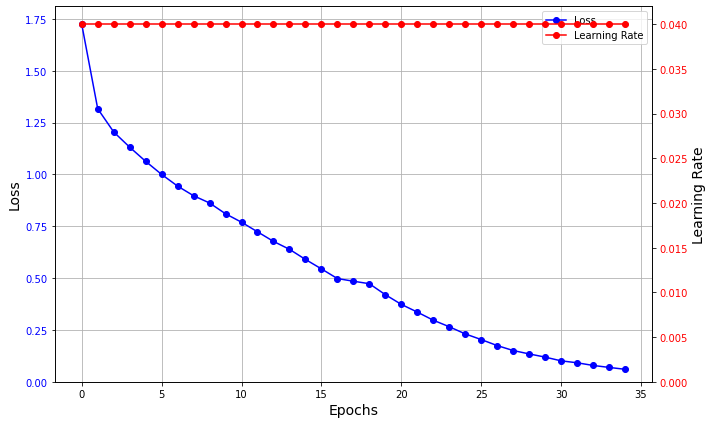

-----------------------------    model_cnnLSTM ----------------------------- 
Epoch: 1/[35, 50] - learning rate: 0.00400, classification loss: 1.6655
Epoch: 2/[35, 50] - learning rate: 0.00400, classification loss: 1.2946
Epoch: 3/[35, 50] - learning rate: 0.00400, classification loss: 1.1691
Epoch: 4/[35, 50] - learning rate: 0.00400, classification loss: 1.0864
Epoch: 5/[35, 50] - learning rate: 0.00400, classification loss: 1.0039
Epoch: 6/[35, 50] - learning rate: 0.00400, classification loss: 0.9341
Epoch: 7/[35, 50] - learning rate: 0.00400, classification loss: 0.8641
Epoch: 8/[35, 50] - learning rate: 0.00400, classification loss: 0.8125
Epoch: 9/[35, 50] - learning rate: 0.00400, classification loss: 0.7664
Epoch: 10/[35, 50] - learning rate: 0.00400, classification loss: 0.7152
Epoch: 11/[35, 50] - learning rate: 0.00400, classification loss: 0.6839
Epoch: 12/[35, 50] - learning rate: 0.00400, classification loss: 0.6340
Epoch: 13/[35, 50] - learning rate: 0.00400, classifica

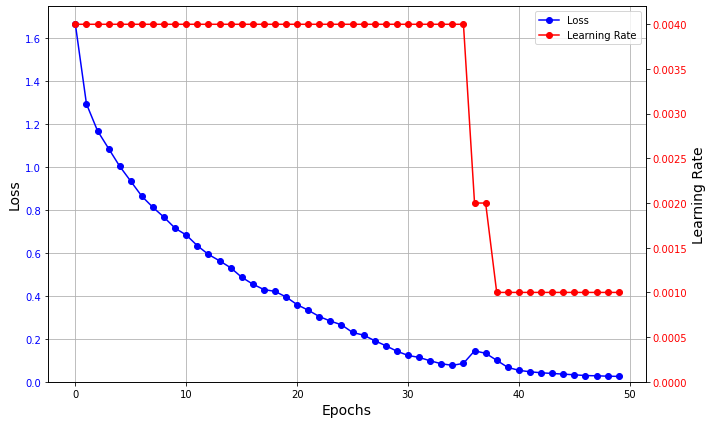

In [100]:
# Create a DataLoader for the combined dataset
train_dataloader = DataLoader(master_dataset_franka, batch_size=batch_size, shuffle=True)

n_epochs = [35, 50]

lrs = [0.04, 0.004]
lr_threshold = 0.0005

for ii in range(len(models)):
    model = models[ii]
    #model.lstm.flatten_parameters()
    
    lr = lrs[ii]
    print('-----------------------------   ', models_names[ii],'----------------------------- ')
    #  training on source robot
    #model, loss_seq, lr_seq = train_loop(model, train_datasetloader,selected_features, lr, n_epochs[ii])
    dataset_loader = train_datasetloader
    model.train()
    # Use Adam optimizer and CrossEntropyLoss as the loss function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
    loss_seq = []
    lr_seq = []
    # Training loop
    for epoch in range(n_epochs[ii]):
        running_loss = []
        
        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) # Move data to device
            optimizer.zero_grad()
            # Generate noise and shift as PyTorch tensors
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy())

        avg_loss = np.mean(running_loss)
        print(f"Epoch: {epoch + 1}/{n_epochs} - learning rate: {optimizer.param_groups[0]['lr']:.5f}, classification loss: {avg_loss:.4f}")
        # Update the scheduler with the average loss
        scheduler.step(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < lr_threshold:
            print(f"Learning rate has dropped below the threshold of {lr_threshold}. Stopping training.")
            break
        loss_seq.append(avg_loss)
        lr_seq.append(current_lr)

    plot_loss(loss_seq, lr_seq)
     
    # Validation
    #pre_training_accuracies = validation(test_dataloaders, dataloaders_names, model)
    #print(pre_training_accuracies)

## test on franka robot

In [101]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go

data_path = '/home/rzma/myProjects/contactInterpretation/frankaRobot/DATA/dataset/e4/labeled_data.csv'
data_path = '/home/rzma/myProjects/contactInterpretation/dataset/franka_mindlab/labeled_data/link3/t1.csv'

def get_features_dof(features, joint_number):
    j = joint_number
    feature_j = []
    for i in range(len(features)) :
        feature_j.append(f'{features[i]}{j}' )
    return feature_j

# trained with training set
#contact_detection_path= main_path + 'model_cnnLSTMtest_source_robot.pth'

#model_contact = copy.deepcopy(models[0])
#checkpoint = torch.load(contact_detection_path)
#model_contact.load_state_dict(checkpoint["model_state_dict"])
#model_contact.to(device)

features = ['tau_J', 'tau_ext', 'e', 'de']
features = ['e']
dof = 7
#features_num = len(features)*dof

window_length = seq_num
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
testing_data = pd.read_csv(data_path)
testing_data['model_out'] = testing_data.label
testing_data['probability'] = testing_data.label
#testing_data = testing_data[(testing_data.index > 3000) & (testing_data.index < 5000)]; testing_data.reset_index(inplace=True)
#testing_data = testing_data[(testing_data.index < 4000)]; testing_data.reset_index(inplace=True)

for model_contact in models:
    #model_contact = copy.deepcopy(model)
    model_contact.eval()

    for t_i in range(window_length, testing_data.shape[0]):
        #building data window
        window = []
        for joint_number in range(dof):
            feature_j = get_features_dof(features=features, joint_number=joint_number)
            joint_row = np.hstack(testing_data[feature_j][t_i-window_length:t_i].values)
            window.append(joint_row)
            
        window = np.array([window])
        window = torch.tensor(window).to(device)
        with torch.no_grad():
            model_out = model_contact(window.float())
            #model_out = (model_out > 0.8).int() 
            probabilities = F.softmax(model_out) 
            testing_data.loc[t_i-1, 'probability'] = probabilities[probabilities.argmax().item()].item()
            testing_data.loc[t_i-1, 'model_out'] = probabilities.argmax().item() #probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()
            
            '''
            if testing_data.loc[t_i-1, 'probability'] > 0.2:
                testing_data.loc[t_i-1, 'model_out'] = probabilities.argmax().item()+1 #probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()
            else:
                testing_data.loc[t_i-1, 'model_out'] = 0'''

    # Create traces for the first dataset
    traces = []
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['model_out'], mode='lines', name='model_out'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['probability'], mode='lines', name='probability'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['label'], mode='lines', name='label'))

    # Create the layout
    layout = go.Layout(
        title='Combined Plot',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Values'),
        showlegend=True
    )

    # Create the figure and plot it
    fig = go.Figure(data=traces, layout=layout)
    fig.show()
    # calculate latency per contact event
    n = 80
    detection_delays = []
    true_label_index = testing_data.label[testing_data.label.diff()>0.9].index
    no_contact_start_index = testing_data.label[testing_data.label.diff()<-0.8].index
    no_contact_start_index = no_contact_start_index[no_contact_start_index>true_label_index[0]]

    predicted_label_index = testing_data.model_out[testing_data.model_out.diff()>0.9].index
    true_positive= np.zeros_like(true_label_index)
    counter = 0
    for i, end_i in zip(true_label_index, no_contact_start_index):
        state = False
        for j in range(end_i-i): 
            #if testing_data.model_out[i+j]:
            if (i+j) in predicted_label_index:
                detection_delays.append(testing_data.time[i+j]-testing_data.time[i])
                true_positive[counter]=1
                counter = counter +1
                state=True
                break
        if not state:
            true_positive[counter]=0
            counter = counter +1


    print('Single contact analysis')
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
    print(f'Effective Detection delay: {np.sum(detection_delays)/len(detection_delays):.3f} seconds')
    %matplotlib inline
    #plt.hist(detection_delays, bins=20)
    #plt.show()
    #plt.boxplot(detection_delays)

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 20,   contact labels: 20, percision: 1.0 
Effective Detection delay: 0.027 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 18,   contact labels: 20, percision: 0.9 
Effective Detection delay: 0.026 seconds


## test on UR5 robot

In [10]:
data_path =  '/home/rzma/myProjects/contactInterpretation/dataset/ur5/labeled_data/link5/t2.csv'
def get_features_dof(features, joint_number):
    j = joint_number
    feature_j = []
    for i in range(len(features)) :
        feature_j.append(f'{features[i]}{j}' )
    return feature_j


features = ['target_moment_', 'e_i', 'e', 'de']
features = ['e']
dof = 6
#features_num = len(features)*dof

window_length = seq_num

k_tau = np.array([0.1082, 0.1100, 0.1097, 0.0787, 0.0294, 0.0261])*10 #ur robot support file
#k_tau = [1.35,  1.361, 1.355, 0.957, 0.865, 0.893] #my finding
#k_tau = np.array([0.1155, 0.1149 , 0.0988, 0.1032, 0.1033, 0.1030])*10 #ur10e
e_i = [f'e_i{i}' for i in range(dof)]

testing_data = pd.read_csv(data_path)
for i in range(len(e_i)):
    testing_data[e_i[i]]=testing_data[e_i[i]]*k_tau[i]

testing_data['model_out'] = testing_data.label
testing_data['probability'] = testing_data.label
#testing_data = testing_data[testing_data.index > 4000]; testing_data.reset_index(inplace=True)
# trained with training set
'''contact_detection_path= main_path + 'sequencetest_ur5.pth'

model_contact = copy.deepcopy(models[2])
checkpoint = torch.load(contact_detection_path)
model_contact.load_state_dict(checkpoint["model_state_dict"])
model_contact.to(device)
'''

for model_contact in models:
    model_contact.eval()

    for t_i in range(window_length, testing_data.shape[0]):
        #building data window
        window = []
        for joint_number in range(dof):
            feature_j = get_features_dof(features=features, joint_number=joint_number)
            joint_row = np.hstack(testing_data[feature_j][t_i-window_length:t_i].values)
            window.append(joint_row)
            
        #window = np.array(window)
        window = np.array([window])
        window_transformed = torch.tensor(window).to(device)
        with torch.no_grad():
            model_out = model_contact(window_transformed.float())
            #model_out = (model_out > 0.8).int() 
            probabilities = F.softmax(model_out) 
            testing_data.loc[t_i-1, 'probability'] = probabilities[probabilities.argmax().item()].item()
            testing_data.loc[t_i-1, 'model_out'] = probabilities.argmax().item() #probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()

            
            '''if testing_data.loc[t_i-1, 'probability'] > 0.2:
                testing_data.loc[t_i-1, 'model_out'] = probabilities.argmax().item()+1 #probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()
            else:
                testing_data.loc[t_i-1, 'model_out'] = 0'''


    # Create traces for the first dataset
    traces = []
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['model_out'], mode='lines', name='model_out'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['probability'], mode='lines', name='probability'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['label'], mode='lines', name='label'))


    # Create the layout
    layout = go.Layout(
        title='Combined Plot',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Values'),
        showlegend=True
    )

    # Create the figure and plot it
    fig = go.Figure(data=traces, layout=layout)
    fig.show()
    # calculate latency per contact event
    n = 80
    detection_delays = []
    true_label_index = testing_data.label[testing_data.label.diff()>0.9].index
    no_contact_start_index = testing_data.label[testing_data.label.diff()<-0.8].index
    no_contact_start_index = no_contact_start_index[no_contact_start_index>true_label_index[0]]

    predicted_label_index = testing_data.model_out[testing_data.model_out.diff()>0.9].index
    true_positive= np.zeros_like(true_label_index)
    counter = 0
    for i, end_i in zip(true_label_index, no_contact_start_index):
        state = False
        for j in range(end_i-i): 
            #if testing_data.model_out[i+j]:
            if (i+j) in predicted_label_index:
                detection_delays.append(testing_data.time[i+j]-testing_data.time[i])
                true_positive[counter]=1
                counter = counter +1
                state=True
                break
        if not state:
            true_positive[counter]=0
            counter = counter +1


    print('Single contact analysis')
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
    print(f'Effective Detection delay: {np.sum(detection_delays)/len(detection_delays):.3f} seconds')
    %matplotlib inline
    #plt.hist(detection_delays, bins=20)
    #plt.show()
    #plt.boxplot(detection_delays)
    

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 15,   contact labels: 15, percision: 1.0 
Effective Detection delay: 0.028 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 15,   contact labels: 15, percision: 1.0 
Effective Detection delay: 0.048 seconds


# 4. Fine Tuning

In [112]:
from torch.utils.data import Subset, ConcatDataset

data_path = os.getcwd().replace('AIModels','') +'/dataset/ur5/labeled_data/'
dict_label = dict_label = {'link6':5, 'link5':4, 'link4':3, 'link3':2, 'link2':1, 'link1':0}

robot_dof = 6
seq_num = 64
gap = 5
selected_features = [f'e{i}' for i in range(robot_dof)]#+[ f'de{i}' for i in range(robot_dof)]


batch_size = 4096
num_classes = 7

# Load data and create training and testing sets

testing_datasets = LoadDatasets(data_path, dict_label)
test_datasetloader = DataLoader(testing_datasets, batch_size=1, shuffle=True)

# Initialize counters
total_samples_counter = 0
train_samples_counter = 0
master_dataset = []

# Iterate through test_datasetloader
for trial_dataset_path, label in test_datasetloader:
    # Load the dataset for the trial
    data = LoadSeqDataset(file_path=trial_dataset_path[0], label=label[0], selected_features=selected_features, seq_num=seq_num, gap=gap)

    # Count total samples
    total_samples = len(data)
    total_samples_counter += total_samples

    # Calculate number of samples for the subset (5% of the data)
    num_samples = int(0.1 * total_samples)
    train_samples_counter += num_samples

    # Randomly sample indices
    indices = torch.randperm(total_samples).tolist()[:num_samples]

    # Create a subset of the data
    subset_data = Subset(data, indices)
    master_dataset.append(subset_data)

# Combine all subsets into a single dataset
master_dataset_ur5 = ConcatDataset(master_dataset)

# Create a DataLoader for the combined dataset
train_dataloader = DataLoader(master_dataset_ur5, batch_size=batch_size, shuffle=True)

print(f"Total samples across all trials: {total_samples_counter}")
print(f"Total samples used for training (5% of data): {train_samples_counter}")

Total samples across all trials: 13266
Total samples used for training (5% of data): 1321


-----------------------------    model_lstmBlock ----------------------------- 
Epoch: 1/[25, 40] - learning rate: 0.01000, classification loss: 1.8763
Epoch: 2/[25, 40] - learning rate: 0.01000, classification loss: 1.4783
Epoch: 3/[25, 40] - learning rate: 0.01000, classification loss: 1.1601
Epoch: 4/[25, 40] - learning rate: 0.01000, classification loss: 0.9494
Epoch: 5/[25, 40] - learning rate: 0.01000, classification loss: 0.7845
Epoch: 6/[25, 40] - learning rate: 0.01000, classification loss: 0.6533
Epoch: 7/[25, 40] - learning rate: 0.01000, classification loss: 0.5572
Epoch: 8/[25, 40] - learning rate: 0.01000, classification loss: 0.4738
Epoch: 9/[25, 40] - learning rate: 0.01000, classification loss: 0.4046
Epoch: 10/[25, 40] - learning rate: 0.01000, classification loss: 0.3512
Epoch: 11/[25, 40] - learning rate: 0.01000, classification loss: 0.3036
Epoch: 12/[25, 40] - learning rate: 0.01000, classification loss: 0.2587
Epoch: 13/[25, 40] - learning rate: 0.01000, classifi

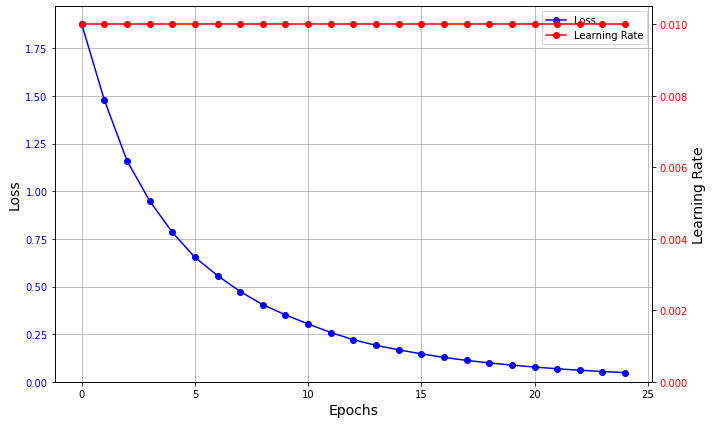

-----------------------------    model_cnnLSTM ----------------------------- 
Epoch: 1/[25, 40] - learning rate: 0.00200, classification loss: 2.2384
Epoch: 2/[25, 40] - learning rate: 0.00200, classification loss: 1.6516
Epoch: 3/[25, 40] - learning rate: 0.00200, classification loss: 1.2725
Epoch: 4/[25, 40] - learning rate: 0.00200, classification loss: 0.9784
Epoch: 5/[25, 40] - learning rate: 0.00200, classification loss: 0.7865
Epoch: 6/[25, 40] - learning rate: 0.00200, classification loss: 0.6376
Epoch: 7/[25, 40] - learning rate: 0.00200, classification loss: 0.5323
Epoch: 8/[25, 40] - learning rate: 0.00200, classification loss: 0.4683
Epoch: 9/[25, 40] - learning rate: 0.00200, classification loss: 0.4177
Epoch: 10/[25, 40] - learning rate: 0.00200, classification loss: 0.3674
Epoch: 11/[25, 40] - learning rate: 0.00200, classification loss: 0.3167
Epoch: 12/[25, 40] - learning rate: 0.00200, classification loss: 0.2827
Epoch: 13/[25, 40] - learning rate: 0.00200, classifica

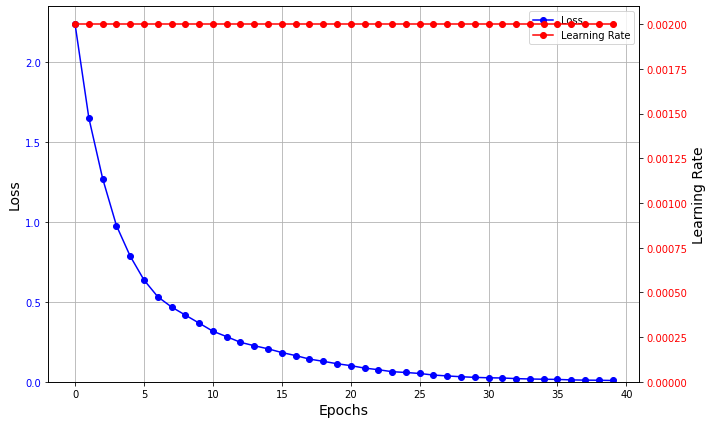

In [113]:
import copy

models_da = copy.deepcopy(models)

n_epochs = [25, 40]
lrs = [0.01, 0.002]

lr_threshold = 0.0005

for ii in range(len(models_da)):
    model = models_da[ii]
    #model.lstm.flatten_parameters()
    
    lr = lrs[ii]
    print('-----------------------------   ', models_names[ii],'----------------------------- ')
    #  training on source robot
    #model, loss_seq, lr_seq = train_loop(model, train_datasetloader,selected_features, lr, n_epochs[ii])
    dataset_loader = test_datasetloader
    model.train()
    # Use Adam optimizer and CrossEntropyLoss as the loss function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
    loss_seq = []
    lr_seq = []
    
    # Training loop
    for epoch in range(n_epochs[ii]):
        running_loss = []
        
        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) # Move data to device
            optimizer.zero_grad()
            # Generate noise and shift as PyTorch tensors
            y_pred = model(X_batch, freeze_last_layer=True)
            loss = loss_fn(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy())

        avg_loss = np.mean(running_loss)
        print(f"Epoch: {epoch + 1}/{n_epochs} - learning rate: {optimizer.param_groups[0]['lr']:.5f}, classification loss: {avg_loss:.4f}")
        # Update the scheduler with the average loss
        scheduler.step(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < lr_threshold:
            print(f"Learning rate has dropped below the threshold of {lr_threshold}. Stopping training.")
            break
        loss_seq.append(avg_loss)
        lr_seq.append(current_lr)
        
    plot_loss(loss_seq, lr_seq)

## test on ur robot

In [114]:
data_path =  '/home/rzma/myProjects/contactInterpretation/dataset/ur5/labeled_data/link5/t2.csv'
import plotly.graph_objs as go
def get_features_dof(features, joint_number):
    j = joint_number
    feature_j = []
    for i in range(len(features)) :
        feature_j.append(f'{features[i]}{j}' )
    return feature_j


features = ['target_moment_', 'e_i', 'e', 'de']
features = ['e']
dof = 6
#features_num = len(features)*dof

window_length = seq_num

k_tau = np.array([0.1082, 0.1100, 0.1097, 0.0787, 0.0294, 0.0261])*13 #ur robot support file
#k_tau = [1.35,  1.361, 1.355, 0.957, 0.865, 0.893] #my finding
#k_tau = np.array([0.1155, 0.1149 , 0.0988, 0.1032, 0.1033, 0.1030])*10 #ur10e
e_i = [f'e_i{i}' for i in range(dof)]

testing_data = pd.read_csv(data_path)
for i in range(len(e_i)):
    testing_data[e_i[i]]=testing_data[e_i[i]]*k_tau[i]

testing_data['model_out'] = testing_data.label
testing_data['probability'] = testing_data.label
#testing_data = testing_data[testing_data.index > 4000]; testing_data.reset_index(inplace=True)
# trained with training set
'''contact_detection_path= main_path + 'sequencetest_ur5.pth'

model_contact = copy.deepcopy(models[2])
checkpoint = torch.load(contact_detection_path)
model_contact.load_state_dict(checkpoint["model_state_dict"])
model_contact.to(device)
'''

for model_contact in models_da:
    model_contact.eval()

    for t_i in range(window_length, testing_data.shape[0]):
        #building data window
        window = []
        for joint_number in range(dof):
            feature_j = get_features_dof(features=features, joint_number=joint_number)
            joint_row = np.hstack(testing_data[feature_j][t_i-window_length:t_i].values)
            window.append(joint_row)
            
        #window = np.array(window)
        window = np.array([window])
        window_transformed = torch.tensor(window).to(device)
        with torch.no_grad():
            model_out = model_contact(window_transformed.float())
            #model_out = (model_out > 0.8).int() 
            probabilities = F.softmax(model_out) 
            testing_data.loc[t_i-1, 'probability'] = probabilities[probabilities.argmax().item()].item()
            testing_data.loc[t_i-1, 'model_out'] = probabilities.argmax().item() #probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()

            
            '''if testing_data.loc[t_i-1, 'probability'] > 0.2:
                testing_data.loc[t_i-1, 'model_out'] = probabilities.argmax().item()+1 #probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()
            else:
                testing_data.loc[t_i-1, 'model_out'] = 0'''


    # Create traces for the first dataset
    traces = []
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['model_out'], mode='lines', name='model_out'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['probability'], mode='lines', name='probability'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['label'], mode='lines', name='label'))

    
    # Create the layout
    layout = go.Layout(
        title='Combined Plot',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Values'),
        showlegend=True
    )

    # Create the figure and plot it
    fig = go.Figure(data=traces, layout=layout)
    fig.show()
    # calculate latency per contact event
    n = 80
    detection_delays = []
    true_label_index = testing_data.label[testing_data.label.diff()>0.9].index
    no_contact_start_index = testing_data.label[testing_data.label.diff()<-0.8].index
    no_contact_start_index = no_contact_start_index[no_contact_start_index>true_label_index[0]]

    predicted_label_index = testing_data.model_out[testing_data.model_out.diff()>0.9].index
    true_positive= np.zeros_like(true_label_index)
    counter = 0
    for i, end_i in zip(true_label_index, no_contact_start_index):
        state = False
        for j in range(end_i-i): 
            #if testing_data.model_out[i+j]:
            if (i+j) in predicted_label_index:
                detection_delays.append(testing_data.time[i+j]-testing_data.time[i])
                true_positive[counter]=1
                counter = counter +1
                state=True
                break
        if not state:
            true_positive[counter]=0
            counter = counter +1


    print('Single contact analysis')
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
    print(f'Effective Detection delay: {np.sum(detection_delays)/len(detection_delays):.3f} seconds')
    %matplotlib inline
    #plt.hist(detection_delays, bins=20)
    #plt.show()
    #plt.boxplot(detection_delays)
    

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 15,   contact labels: 15, percision: 1.0 
Effective Detection delay: 0.038 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 15,   contact labels: 15, percision: 1.0 
Effective Detection delay: 0.048 seconds


# 5. Domain Adaptation

In [35]:
from torch.utils.data import Subset, ConcatDataset
robot_dof = 7
seq_num = 64
gap = 5
selected_features = [f'e{i}' for i in range(robot_dof)]#+[ f'de{i}' for i in range(robot_dof)]

batch_size = 4096
num_classes = 8

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print("Using GPU:", torch.cuda.get_device_name())


# Build the model
model_lstmBlock = lstmBlock(num_features_joints=seq_num, num_layers=1, hidden_size=64, dropout=0.2, bidirectional=True)
model_cnnLSTM = cnnLSTM(num_features_joints=seq_num, num_layers=1, hidden_size=64, dropout=0.2, bidirectional=True)
models = [model_lstmBlock, model_cnnLSTM]
models_names = ['model_lstmBlock',  'model_cnnLSTM',]
for model in models:
    model.to(device)

loss_fn = nn.CrossEntropyLoss()

data_path = os.getcwd().replace('AIModels','') +'/dataset/ur5/labeled_data/'
dict_label = dict_label = {'link6':5, 'link5':4, 'link4':3, 'link3':2, 'link2':1, 'link1':0}

robot_dof = 6
seq_num = 64
gap = 5
selected_features = [f'e{i}' for i in range(robot_dof)]#+[ f'de{i}' for i in range(robot_dof)]


batch_size = 1

# Load data and create training and testing sets

testing_datasets = LoadDatasets(data_path, dict_label)
test_datasetloader = DataLoader(testing_datasets, batch_size=1, shuffle=True)

# Initialize counters
total_samples_counter = 0
train_samples_counter = 0
master_dataset = []

# Iterate through test_datasetloader
for trial_dataset_path, label in test_datasetloader:
    # Load the dataset for the trial
    data = LoadSeqDataset(file_path=trial_dataset_path[0], label=label[0], selected_features=selected_features, seq_num=seq_num, gap=gap)

    # Count total samples
    total_samples = len(data)
    total_samples_counter += total_samples

    # Calculate number of samples for the subset (5% of the data)
    num_samples = int(0.1 * total_samples)
    train_samples_counter += num_samples

    # Randomly sample indices
    indices = torch.randperm(total_samples).tolist()[:num_samples]

    # Create a subset of the data
    subset_data = Subset(data, indices)
    master_dataset.append(subset_data)

master_dataset.append(master_dataset_franka)
# Combine all subsets into a single dataset

da_dataset =ConcatDataset(master_dataset)
# Create a DataLoader for the combined dataset

In [75]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Extract sequences and labels
    sequences = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Compute sequence lengths before padding
    lengths = [len(seq) for seq in sequences]

    # Pad sequences to the same length
    padded_sequences = pad_sequence(sequences, batch_first=True)

    # Convert labels to tensor
    labels = torch.tensor(labels)

    return padded_sequences, labels, lengths  # Include lengths

train_dataloader = DataLoader(da_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


-----------------------------    model_lstmBlock ----------------------------- 
Epoch: 1/[50, 60] - learning rate: 0.04000, classification loss: 1.6195
Epoch: 2/[50, 60] - learning rate: 0.04000, classification loss: 1.2823
Epoch: 3/[50, 60] - learning rate: 0.04000, classification loss: 1.1442
Epoch: 4/[50, 60] - learning rate: 0.04000, classification loss: 1.0476
Epoch: 5/[50, 60] - learning rate: 0.04000, classification loss: 1.0157
Epoch: 6/[50, 60] - learning rate: 0.04000, classification loss: 0.9919
Epoch: 7/[50, 60] - learning rate: 0.04000, classification loss: 0.9333
Epoch: 8/[50, 60] - learning rate: 0.04000, classification loss: 0.9061
Epoch: 9/[50, 60] - learning rate: 0.04000, classification loss: 0.8366
Epoch: 10/[50, 60] - learning rate: 0.04000, classification loss: 0.8389
Epoch: 11/[50, 60] - learning rate: 0.04000, classification loss: 0.7915
Epoch: 12/[50, 60] - learning rate: 0.04000, classification loss: 0.7747
Epoch: 13/[50, 60] - learning rate: 0.04000, classifi

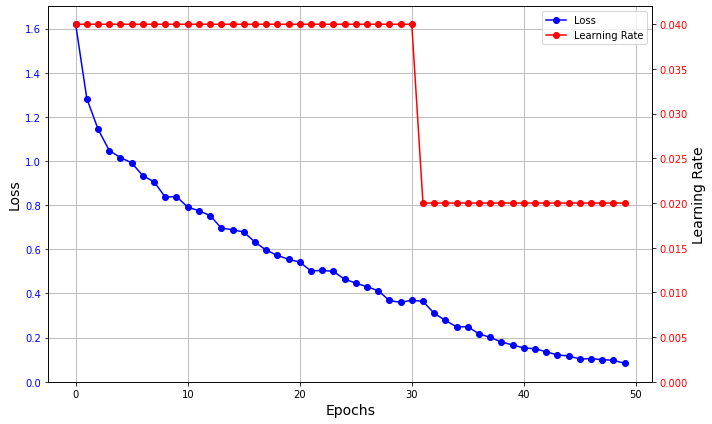

-----------------------------    model_cnnLSTM ----------------------------- 
Epoch: 1/[50, 60] - learning rate: 0.00400, classification loss: 1.5959
Epoch: 2/[50, 60] - learning rate: 0.00400, classification loss: 1.2191
Epoch: 3/[50, 60] - learning rate: 0.00400, classification loss: 1.1270
Epoch: 4/[50, 60] - learning rate: 0.00400, classification loss: 1.0471
Epoch: 5/[50, 60] - learning rate: 0.00400, classification loss: 0.9837
Epoch: 6/[50, 60] - learning rate: 0.00400, classification loss: 0.9731
Epoch: 7/[50, 60] - learning rate: 0.00400, classification loss: 0.9114
Epoch: 8/[50, 60] - learning rate: 0.00400, classification loss: 0.8196
Epoch: 9/[50, 60] - learning rate: 0.00400, classification loss: 0.7843
Epoch: 10/[50, 60] - learning rate: 0.00400, classification loss: 0.7673
Epoch: 11/[50, 60] - learning rate: 0.00400, classification loss: 0.7660
Epoch: 12/[50, 60] - learning rate: 0.00400, classification loss: 0.7064
Epoch: 13/[50, 60] - learning rate: 0.00400, classifica

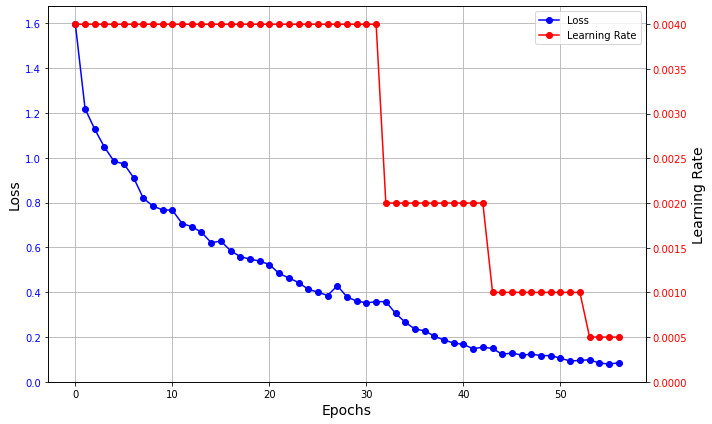

In [89]:
import copy

models_da = copy.deepcopy(models)

n_epochs = [50, 60]
lrs = [0.04, 0.004]

lr_threshold = 0.0005

for ii in range(len(models_da)):
    model = models_da[ii]
    #model.lstm.flatten_parameters()
    
    lr = lrs[ii]
    print('-----------------------------   ', models_names[ii],'----------------------------- ')
    #  training on source robot
    #model, loss_seq, lr_seq = train_loop(model, train_datasetloader,selected_features, lr, n_epochs[ii])
    dataset_loader = test_datasetloader
    model.train()
    # Use Adam optimizer and CrossEntropyLoss as the loss function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
    loss_seq = []
    lr_seq = []
    
    # Training loop
    for epoch in range(n_epochs[ii]):
        running_loss = []
        
        for X_batch, y_batch ,seq_lengths in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) # Move data to device
            optimizer.zero_grad()
            # Generate noise and shift as PyTorch tensors
            y_pred = model(X_batch,seq_lengths, freeze_last_layer=False)
            loss = loss_fn(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy())

        avg_loss = np.mean(running_loss)
        print(f"Epoch: {epoch + 1}/{n_epochs} - learning rate: {optimizer.param_groups[0]['lr']:.5f}, classification loss: {avg_loss:.4f}")
        # Update the scheduler with the average loss
        scheduler.step(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < lr_threshold:
            print(f"Learning rate has dropped below the threshold of {lr_threshold}. Stopping training.")
            break
        loss_seq.append(avg_loss)
        lr_seq.append(current_lr)
        
    plot_loss(loss_seq, lr_seq)

## test on ur robot

In [90]:
data_path =  '/home/rzma/myProjects/contactInterpretation/dataset/ur5/labeled_data/link5/t2.csv'
import plotly.graph_objs as go
def get_features_dof(features, joint_number):
    j = joint_number
    feature_j = []
    for i in range(len(features)) :
        feature_j.append(f'{features[i]}{j}' )
    return feature_j


features = ['target_moment_', 'e_i', 'e', 'de']
features = ['e']
dof = 6
#features_num = len(features)*dof

window_length = seq_num

k_tau = np.array([0.1082, 0.1100, 0.1097, 0.0787, 0.0294, 0.0261])*13 #ur robot support file
#k_tau = [1.35,  1.361, 1.355, 0.957, 0.865, 0.893] #my finding
#k_tau = np.array([0.1155, 0.1149 , 0.0988, 0.1032, 0.1033, 0.1030])*10 #ur10e
e_i = [f'e_i{i}' for i in range(dof)]

testing_data = pd.read_csv(data_path)
for i in range(len(e_i)):
    testing_data[e_i[i]]=testing_data[e_i[i]]*k_tau[i]

testing_data['model_out'] = testing_data.label
testing_data['probability'] = testing_data.label
#testing_data = testing_data[testing_data.index > 4000]; testing_data.reset_index(inplace=True)
# trained with training set
'''contact_detection_path= main_path + 'sequencetest_ur5.pth'

model_contact = copy.deepcopy(models[2])
checkpoint = torch.load(contact_detection_path)
model_contact.load_state_dict(checkpoint["model_state_dict"])
model_contact.to(device)
'''

for model_contact in models_da:
    model_contact.eval()

    for t_i in range(window_length, testing_data.shape[0]):
        #building data window
        window = []
        for joint_number in range(dof):
            feature_j = get_features_dof(features=features, joint_number=joint_number)
            joint_row = np.hstack(testing_data[feature_j][t_i-window_length:t_i].values)
            window.append(joint_row)
            
        #window = np.array(window)
        window = np.array([window])
        window_transformed = torch.tensor(window).to(device)
        with torch.no_grad():
            model_out = model_contact(window_transformed.float(), torch.tensor([6]))
            #model_out = (model_out > 0.8).int() 
            probabilities = F.softmax(model_out) 
            testing_data.loc[t_i-1, 'probability'] = probabilities[probabilities.argmax().item()].item()
            testing_data.loc[t_i-1, 'model_out'] = probabilities.argmax().item() #probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()

            
            '''if testing_data.loc[t_i-1, 'probability'] > 0.2:
                testing_data.loc[t_i-1, 'model_out'] = probabilities.argmax().item()+1 #probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()
            else:
                testing_data.loc[t_i-1, 'model_out'] = 0'''


    # Create traces for the first dataset
    traces = []
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['model_out'], mode='lines', name='model_out'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['probability'], mode='lines', name='probability'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['label'], mode='lines', name='label'))

    
    # Create the layout
    layout = go.Layout(
        title='Combined Plot',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Values'),
        showlegend=True
    )

    # Create the figure and plot it
    fig = go.Figure(data=traces, layout=layout)
    fig.show()
    # calculate latency per contact event
    n = 80
    detection_delays = []
    true_label_index = testing_data.label[testing_data.label.diff()>0.9].index
    no_contact_start_index = testing_data.label[testing_data.label.diff()<-0.8].index
    no_contact_start_index = no_contact_start_index[no_contact_start_index>true_label_index[0]]

    predicted_label_index = testing_data.model_out[testing_data.model_out.diff()>0.9].index
    true_positive= np.zeros_like(true_label_index)
    counter = 0
    for i, end_i in zip(true_label_index, no_contact_start_index):
        state = False
        for j in range(end_i-i): 
            #if testing_data.model_out[i+j]:
            if (i+j) in predicted_label_index:
                detection_delays.append(testing_data.time[i+j]-testing_data.time[i])
                true_positive[counter]=1
                counter = counter +1
                state=True
                break
        if not state:
            true_positive[counter]=0
            counter = counter +1


    print('Single contact analysis')
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
    print(f'Effective Detection delay: {np.sum(detection_delays)/len(detection_delays):.3f} seconds')
    %matplotlib inline
    #plt.hist(detection_delays, bins=20)
    #plt.show()
    #plt.boxplot(detection_delays)
    

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 15,   contact labels: 15, percision: 1.0 
Effective Detection delay: 0.046 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 15,   contact labels: 15, percision: 1.0 
Effective Detection delay: 0.031 seconds
